# Assignment 2

In [11]:
import os
import csv
import numpy as np
import tensorflow as tf
import random
import tqdm
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split

path = f'{os.getcwd()}/'
%cd $path

C:\Users\Berkan\Documents\Semesterfiler\Side-stuff\Deep-learning\assignment02



# Preprocessing

In [17]:
def cleanup(wanted=True):
    files = ['train.npz', 'val.npz', 'test.npz']

    if wanted:
        for file in files:
            if os.path.exists('./data/temp/' + file):
                os.remove('./data/temp/' + file)

        print('Cleanup finished!\n')
    else:
        print('Cleanup aborted!\n')


def create_and_load_data(img_path, meta_file, return_dict=False):
    random.seed(420)

    with open(meta_file, newline='') as csv_file:
        meta_list = list(csv.reader(csv_file, delimiter=',', quotechar='|'))[1:]

    random.shuffle(meta_list)

    img_names = [meta[1] for meta in meta_list]
    lesion_types = [meta[2] for meta in meta_list]

    label_dict = {}

    for i, lesion in enumerate(np.unique(lesion_types)):
        label_dict[lesion] = i

    # img_path er stien til mappen med det samlede HAM_10000 datasæt
    # meta_file er metadata-filen i .csv format.
    if os.path.exists('./data/temp/train.npz') and os.path.exists('./data/temp/val.npz') and os.path.exists(
            './data/temp/test.npz'):
        train_data = np.load('./data/temp/train.npz')
        val_data = np.load('./data/temp/val.npz')
        test_data = np.load('./data/temp/test.npz')
        data = {'train': train_data, 'val': val_data, 'test': test_data}

        if return_dict == False:
            return data
        else:
            return data, label_dict

    arrays = []
    labels = []

    # Load images and labels
    for i, name in tqdm.tqdm(enumerate(img_names)):
        img_array = np.array(tf.keras.utils.load_img(img_path + name + '.jpg', target_size=(68, 68)))
        arrays.append(img_array)
        labels.append(label_dict[lesion_types[i]])

    n_data = len(labels)
    print(f'Number of images: {n_data}')

    arrays = np.array(arrays, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    # Count number of images in each class
    unique, counts = np.unique(labels, return_counts=True)
    print('\nImages by label:\t', "   ".join(list(label_dict.keys())))
    print("Images by class:\t", counts, "\n")

    # Split data into train, validation and test
    X_train, X_test, Y_train, Y_test = train_test_split(
        arrays, labels, shuffle=True, stratify=labels, test_size=0.1
    )

    X_train, val_images, Y_train, val_labels = train_test_split(
        X_train, Y_train, stratify=Y_train, test_size=0.1
    )

    np.savez('./data/temp/train.npz', arrays=X_train, labels=Y_train)
    np.savez('./data/temp/val.npz', arrays=val_images, labels=val_labels)
    np.savez('./data/temp/test.npz', arrays=X_test, labels=Y_test)

    train_data = np.load('./data/temp/train.npz')
    val_data = np.load('./data/temp/val.npz')
    test_data = np.load('./data/temp/test.npz')

    data = {'train': train_data, 'val': val_data, 'test': test_data}

    if return_dict == False:
        return data
    else:
        return data, label_dict



# Load and create data

In [19]:
# --------------------------------- Load or create data ---------------------------------
cleanup(wanted=False)

data, label_dict = create_and_load_data('./data/images/', './data/HAM10000_metadata.csv', return_dict=True)

train_images, Y_train = data['train']['arrays'], data['train']['labels']
val_images, Y_val = data['val']['arrays'], data['val']['labels']
test_images, Y_test = data['test']['arrays'], data['test']['labels']

train_labels = tf.keras.utils.to_categorical(Y_train, num_classes=7)
val_labels = tf.keras.utils.to_categorical(Y_val, num_classes=7)
test_labels = tf.keras.utils.to_categorical(Y_test, num_classes=7)

print("Total Training:\t\t", train_images.shape, train_labels.shape)
print("Total Validation:\t", val_images.shape, val_labels.shape)
print("Total Test:\t\t\t", test_images.shape, test_labels.shape)

print('\nImages by label:\t', "   ".join(list(label_dict.keys())))
print("Training set:\t\t", np.sum(train_labels, axis=0))
print("Validation set:\t\t", np.sum(val_labels, axis=0))
print("Test set:\t\t\t", np.sum(test_labels, axis=0))


Cleanup aborted!



10015it [00:48, 205.62it/s]


Number of images: 10015

Images by label:	 akiec   bcc   bkl   df   mel   nv   vasc
Images by class:	 [ 327  514 1099  115 1113 6705  142] 

Total Training:		 (8111, 68, 68, 3) (8111, 7)
Total Validation:	 (902, 68, 68, 3) (902, 7)
Total Test:			 (1002, 68, 68, 3) (1002, 7)

Images by label:	 akiec   bcc   bkl   df   mel   nv   vasc
Training set:		 [ 264.  417.  890.   93.  902. 5430.  115.]
Validation set:		 [ 30.  46.  99.  10. 100. 604.  13.]
Test set:			 [ 33.  51. 110.  12. 111. 671.  14.]


# Data augmentation

In [20]:
# --------------------------------- Data augmentation ---------------------------------
# Define transformations to apply to the images
transformations = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Use the ImageDataGenerator to generate additional training data
transformations.fit(train_images)

# Apply the transformations to the training data during training randomly
x_train_augmented = transformations.flow(train_images, train_labels, batch_size=32)

# --------------------------------- Class weights ---------------------------------
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = dict(zip(np.unique(Y_train), class_weights))

# CNN Model

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# --------------------------------- Build model ---------------------------------
input = tf.keras.layers.Input(shape=(68, 68, 3))

# Create the model
model = tf.keras.models.Sequential()

# --------------------------------- Adding layers ---------------------------------
n_layers = 4
n_units = [32, 64, 128, 258, 512]  # 32, 64, 128, 256, 512

model.add(tf.keras.layers.Rescaling(1. / 127.5, offset=-1))

for i in range(n_layers):
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=n_units[i],
                                     kernel_size=(3, 3),
                                     activation='relu',
                                     padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D())
    # model.add(tf.keras.layers.Dropout(rate=0.0))

# Add a global average pooling layer
model.add(tf.keras.layers.Flatten())

# Add a final dense layer with the number of classes
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(7, activation='softmax'))

# Training

In [22]:
# --------------------------------- Train model ---------------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, 68, 68, 3))
model.summary()

history2 = model.fit(x_train_augmented,
                     validation_data=[val_images, val_labels],
                     epochs=100,
                     verbose=1,
                     class_weight=class_weights_dict)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 68, 68, 3)         0         
                                                                 
 batch_normalization (BatchN  (None, 68, 68, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 68, 68, 32)        896       
                                                                 
 batch_normalization_1 (Batc  (None, 68, 68, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                        

# Evaluating model

In [44]:
# ---------------------------------- Evaluate model ---------------------------------
results_train = model.evaluate(x=train_images, y=train_labels)
results_val = model.evaluate(x=val_images, y=val_labels)
results_test = model.evaluate(x=test_images, y=test_labels)

print("\nResults from training")
for i, metric in enumerate(model.metrics_names):
    print('Final training {}: {}'.format(metric, results_train[i]))

print("\nResults from validation")
for i, metric in enumerate(model.metrics_names):
    print('Final validation {}: {}'.format(metric, results_val[i]))

print("\nResults from testing")
for i, metric in enumerate(model.metrics_names):
    print('Final test {}: {}'.format(metric, results_test[i]))

32/32 [==============================] - 1s 39ms/step - loss: 0.8843 - accuracy: 0.7275

Results from training
Final training loss: 0.317746102809906
Final training accuracy: 0.8765873312950134

Results from validation
Final validation loss: 0.8404005765914917
Final validation accuracy: 0.7294900417327881

Results from testing
Final test loss: 0.8842812776565552
Final test accuracy: 0.727544903755188


# Plotting results

------------------ Confusion matrix for training set ------------------
254/254 [==============================] - 11s 43ms/step


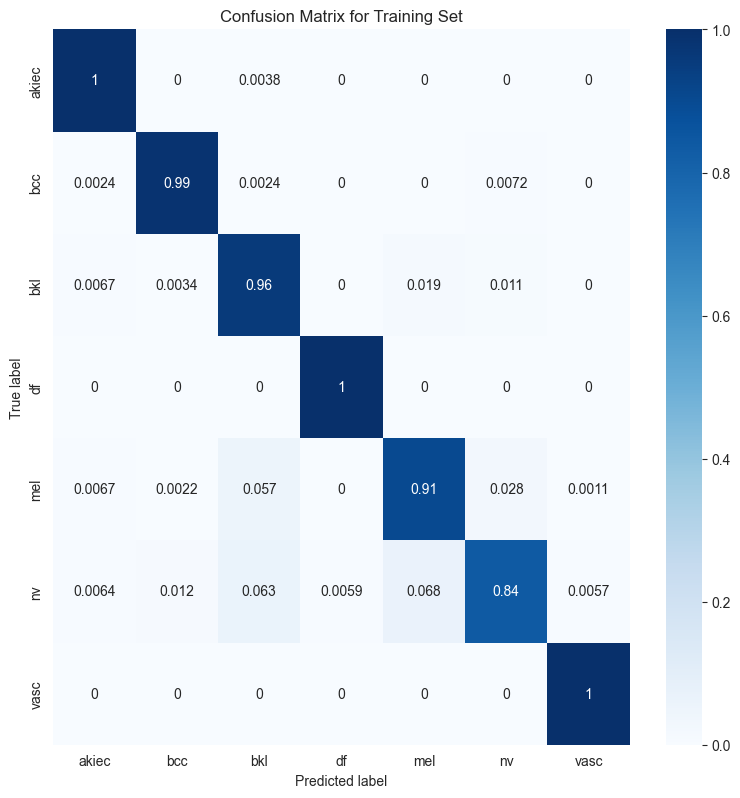

------------------ Confusion matrix for validation set ------------------
29/29 [==============================] - 1s 36ms/step


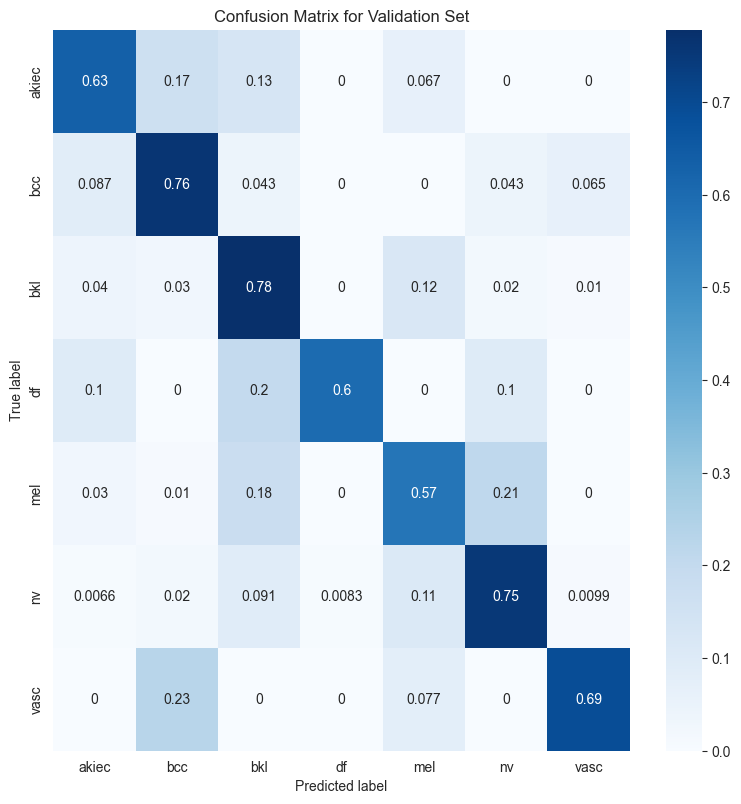

------------------ Confusion matrix for test set ------------------
32/32 [==============================] - 1s 42ms/step


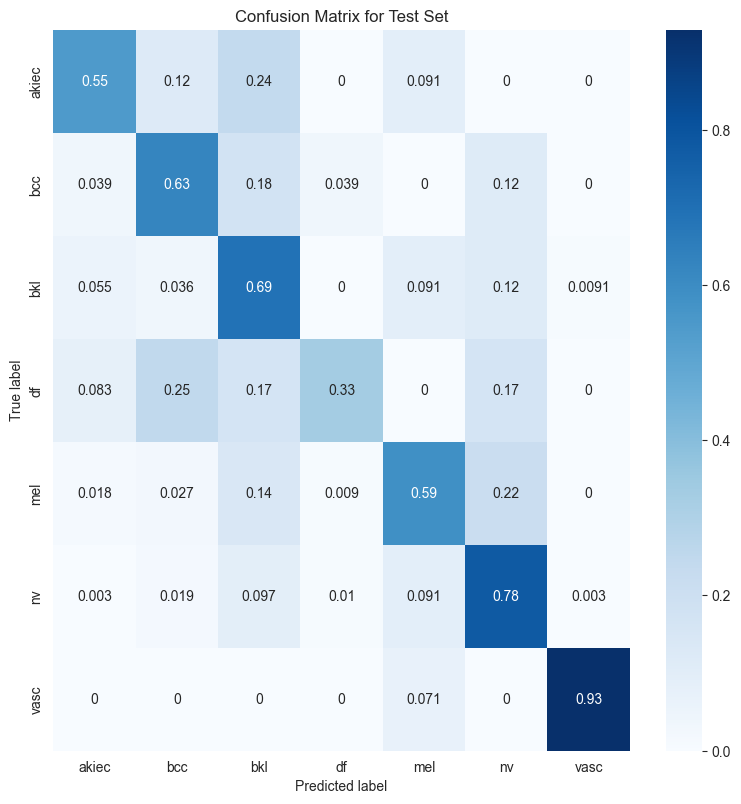

Training loss


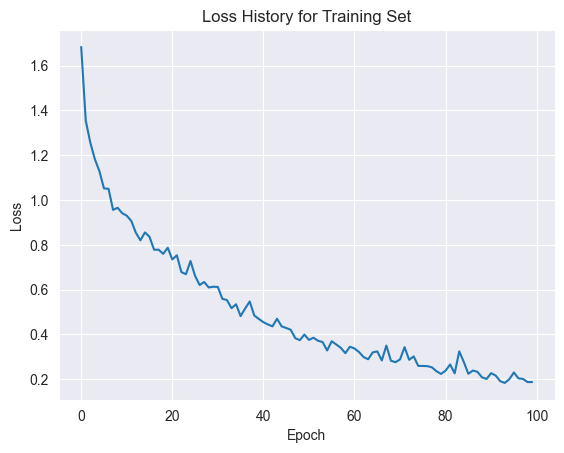

Validation loss


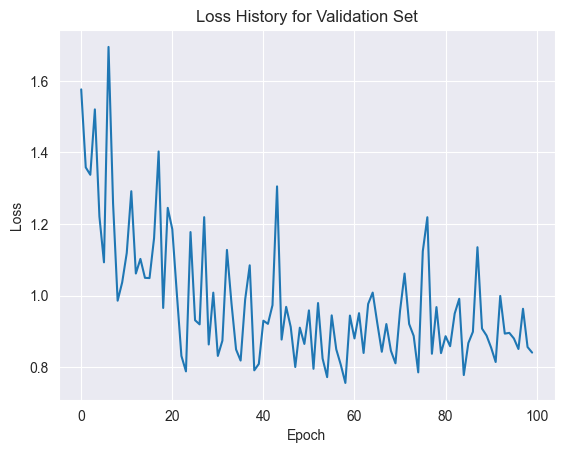

Training accuracy


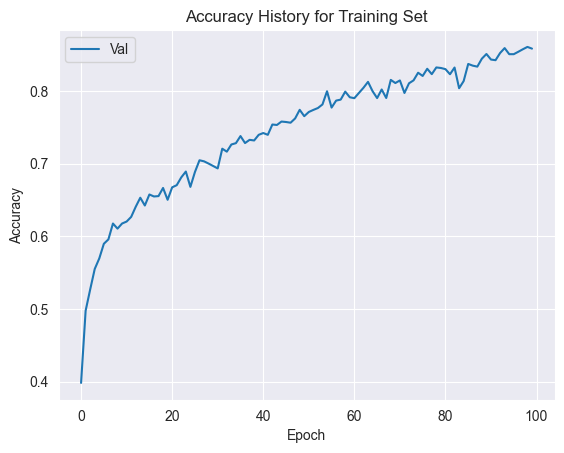

Validation accuracy


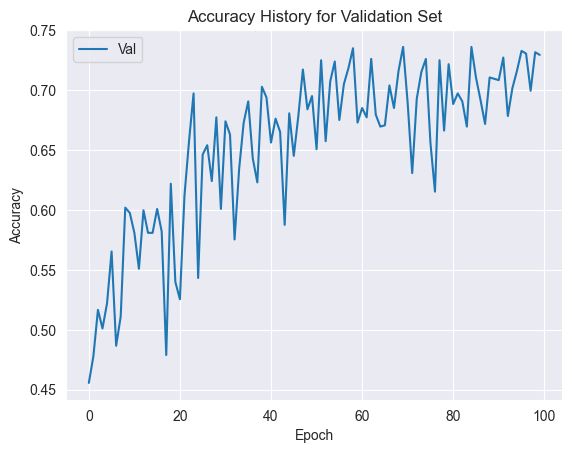

In [33]:
# ---------------------------------- Plot confusion matrix ---------------------------------
print("------------------ Confusion matrix for training set ------------------")
train_preds = model.predict(train_images)

train_pred = np.argmax(train_preds, axis=1)
train_true = np.argmax(train_labels, axis=1)

cm = confusion_matrix(train_true, train_pred)
cm = cm / cm.astype(float).sum(axis=1)[:, np.newaxis]

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm,
            annot=True,
            cmap=plt.cm.Blues,
            xticklabels=label_dict.keys(),
            yticklabels=label_dict.keys())
plt.tight_layout(pad=2)
plt.title('Confusion Matrix for Training Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print("------------------ Confusion matrix for validation set ------------------")
val_preds = model.predict(val_images)

val_pred = np.argmax(val_preds, axis=1)
val_true = np.argmax(val_labels, axis=1)

cm = confusion_matrix(val_true, val_pred)
cm = cm / cm.astype(float).sum(axis=1)[:, np.newaxis]

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm,
            annot=True,
            cmap=plt.cm.Blues,
            xticklabels=label_dict.keys(),
            yticklabels=label_dict.keys())
plt.tight_layout(pad=2)
plt.title('Confusion Matrix for Validation Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print("------------------ Confusion matrix for test set ------------------")
test_preds = model.predict(test_images)

test_pred = np.argmax(test_preds, axis=1)
test_true = np.argmax(test_labels, axis=1)

cm = confusion_matrix(test_true, test_pred)
cm = cm / cm.astype(float).sum(axis=1)[:, np.newaxis]

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm,
            annot=True,
            cmap=plt.cm.Blues,
            xticklabels=label_dict.keys(),
            yticklabels=label_dict.keys())
plt.tight_layout(pad=2)
plt.title('Confusion Matrix for Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
# ---------------------------------- Loss history ---------------------------------
# Training loss
print("Training loss")
plt.plot(history2.history['loss'])
plt.title('Loss History for Training Set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Validation loss
print("Validation loss")
plt.plot(history2.history['val_loss'])
plt.title('Loss History for Validation Set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# ---------------------------------- Accuracy history ---------------------------------
# Training accuracy
print("Training accuracy")
plt.plot(history2.history['accuracy'])
plt.title('Accuracy History for Training Set')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Val'], loc='upper left')
plt.show()

# Validation accuracy
print("Validation accuracy")
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy History for Validation Set')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Val'], loc='upper left')
plt.show()


# Comparing plots

Training and validation accuracy


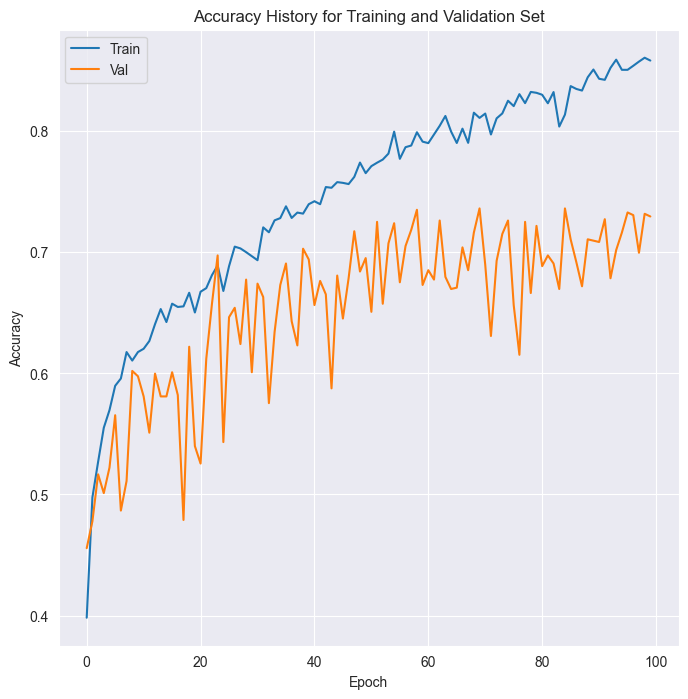

In [39]:
# Plot accuracy history from training
print("Training and validation accuracy")
figure = plt.figure(figsize=(8, 8))
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy History for Training and Validation Set')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Training and validation loss


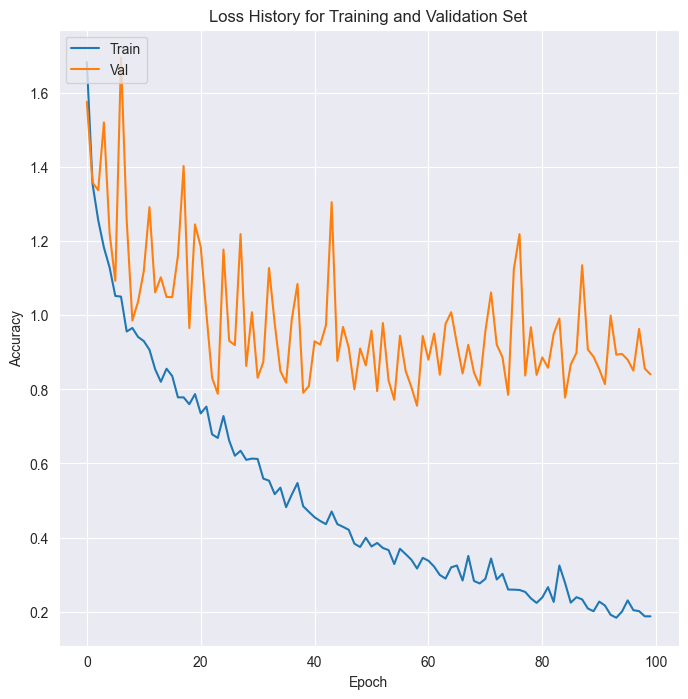

In [38]:
# Plot accuracy history from training
print("Training and validation loss")
figure = plt.figure(figsize=(8, 8))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss History for Training and Validation Set')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
